In [1]:
%load_ext autoreload
import glob
import nibabel
import pandas as pd
import numpy as np

from collections import defaultdict, Counter
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook, tqdm
from joblib import Parallel, delayed

from IPython.core.debugger import set_trace

import os
import shutil
import argparse
import time
import json
import pickle

import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from models.v2v import V2VModel

import yaml
from easydict import EasyDict as edict

from utils import show_slices, check_patch, get_symmetric_value, pad_arrays, create_dicts, normalized, load

from multiprocessing import cpu_count
N_CPU = cpu_count()

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

import cc3d

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important}</style>"))

from celluloid import Camera

SEED = 42
%autoreload 2

In [2]:
USE_GEOM_FEATURES = True
GEOM_FEATURES = ['thickness', 'sulc', 'curv']

root_label = '../fcd_data/normalized_label'
root_data = '../fcd_data/normalized_data/'
root_geom_features = '../fcd_data/preprocessed_data_anadezhda/'

paths_dict = create_dicts(root_label,
                         root_data,
                         root_geom_features, 
                         USE_GEOM_FEATURES, 
                         GEOM_FEATURES)

In [ ]:
def make_tensor(root, label, pdict, padding_size=None):
    
    brain_tensor, mask_tensor, label_tensor = load(pdict)
    
    GEOM_FEATURES = list(set(pdict.keys()) - {'label', 'brain', 'mask'})
    
    ################
    # MAKE TENSORS #
    ################
    if padding_size is not None:
        label_tensor, mask_tensor, brain_tensor = pad_arrays([label_tensor, 
                                                              mask_tensor, 
                                                              brain_tensor],
                                                              padding_size)
        
    label_tensor_torch = torch.tensor(label_tensor, dtype=torch.float32)
    mask_tensor_torch = torch.tensor(mask_tensor, dtype=torch.long)
    brain_tensor_torch = torch.tensor(normalized(brain_tensor), dtype=torch.float32)
    
    torch_tensor = {'brain':brain_tensor_torch, 
                      'mask':mask_tensor_torch,
                      'label':label_tensor_torch}
    
    if USE_GEOM_FEATURES:
        feature_tensors = [nibabel.load(pdict[f'{feature_name}']).get_fdata() \
                           for feature_name in GEOM_FEATURES]
        
        if padding_size is not None:
            feature_tensors = pad_arrays(feature_tensors, padding_size)
            
        for i, feature_name in enumerate(GEOM_FEATURES):
            torch_tensor[feature_name] = torch.tensor(normalized(feature_tensors[i]), dtype=torch.float)
        
    torch.save(torch_tensor, os.path.join(root, f'tensor_{label}'))

_ = Parallel(n_jobs=-1)(delayed(make_tensor)('../fcd_data/normalized_tensors', k,v) for k,v in tqdm(paths_dict.items()))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:04<00:00, 18.75it/s]


In [ ]:
def video(brain_tensor, mask_tensor=None, n_slides=100):
    
    fig, ax = plt.subplots()
    X_max, Y_max, Z_max = brain_tensor.shape
    camera = Camera(fig)
    
    for i in range(n_slides):
        
        y_slice_pos = (Y_max//(n_slides+2))*(i+1)
        
        brain_tensor_slice = brain_tensor[:,y_slice_pos,:]
        ax.imshow(brain_tensor_slice, 'gray')
        
        if mask_tensor is not None:
            
            mask_tensor_slice = mask_tensor[:,y_slice_pos,:]
            ax.imshow(mask_tensor_slice, 'jet', interpolation='none', alpha=0.7)
        
        camera.snap()
        
    return camera   
    

In [ ]:
brain, mask = torch.load('../fcd_data/normalized_tensors/1')

In [ ]:
# brain, mask

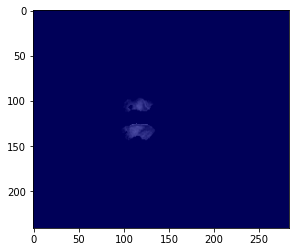

In [68]:
plt.ioff()
# camera = video(*data_test[0])
camera = video(brain.numpy(), mask.numpy())
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

# Metadata

In [ ]:
metadata_root = './metadata'
train_keys, test_keys = train_test_split(list(paths_dict.keys()), test_size=0.1, random_state=SEED)
metadata = {'train_keys':train_keys
            'test_keys':test_keys,
            'seed':SEED}


In [69]:
def get_components(label_tensor, only_number_of_components=False):
    
    results = {}
    
    labels_out = cc3d.connected_components(label_tensor > 0, connectivity=26)
    l, c = np.unique(labels_out, return_counts=True)

    LABEL_TOTAL_PIX_THRESHOLD = 1000
    X,Y,Z = labels_out.shape
    centers ={}
    sizes = {}
    for i,l_i in enumerate(l[1:]):
        if c[i] > LABEL_TOTAL_PIX_THRESHOLD:
            labels_mask = labels_out == l_i

            coordinates = np.stack(np.meshgrid(np.arange(X), np.arange(Y), np.arange(Z), indexing='ij'), -1)[labels_mask]
            center_i = coordinates.mean(0).astype(int)
            size_i = max(coordinates.max(0) - coordinates.min(0))
            centers[l_i] = center_i
            sizes[l_i] = size_i
            
    results['centers'] = centers
    results['sizes'] = sizes
    results['labels_out'] = labels_out
    
    return results

# sizes_all = []
df_eda = defaultdict(dict)
for name,pdict in paths_dict.items():
    brain_tensor, mask_tensor, label_tensor = load(pdict)
    components = get_components(label_tensor)
    
    df_eda[name]['n_components'] = len(components['centers'])
    
#     print (len(components['centers']))
#     sizes_all += list(components['sizes'].values())
    
# sizes_all = np.array(sizes_all)

# With geometrical features

In [19]:
# for label, path_dict in tqdm(paths_dict.items()):
    
#     brain_tensor, mask_tensor, label_tensor = load(path_dict)
#     brain_tensor = normalized(brain_tensor)
    
#     ################
#     # MAKE TENSORS #
#     ################
#     label_tensor, mask_tensor, brain_tensor = pad_arrays([label_tensor, 
#                                                           mask_tensor, 
#                                                           brain_tensor],
#                                                           padding_size)
    
#     brain_tensor_torch = torch.tensor(brain_tensor, dtype=torch.float)
#     label_tensor_torch = torch.tensor(label_tensor, dtype=torch.float)
    
#     if USE_GEOM_FEATURES:
#         feature_tensors = [nibabel.load(path_dict[f'{feature_name}']).get_fdata() \
#                            for feature_name in GEOM_FEATURES]
        
#         feature_tensors_torch = [torch.tensor(feature_tensor, dtype=torch.float) \
#                                 for feature_tensor in pad_arrays(feature_tensors, padding_size)]
    
#         torch_tensor = torch.stack([brain_tensor_torch] + feature_tensors_torch + [label_tensor_torch])
        
#     else:
#         torch_tensor = torch.stack([brain_tensor_torch, 
#                                     label_tensor_torch])
        
#     torch.save(torch_tensor, os.path.join(patches_data_root, f'tensor_{label}'))
    
#     ###########################
#     # CREATE RELEVANT INDEXES #
#     ###########################
#     X,Y,Z = mask_tensor.shape
#     X_mean = X//2
#     thresh_mask = (np.arange(X) < (X_mean - patch_size//2)) | (np.arange(X) > (X_mean + patch_size//2))
#     thresh_mask = np.tile(thresh_mask, (Y,Z,1)).transpose(2,0,1)
#     mask_tensor = mask_tensor*thresh_mask > 0

#     xyz_grid = np.stack(np.meshgrid(np.arange(X), np.arange(Y), np.arange(Z), indexing='ij'), -1)
#     xyz_grid = xyz_grid[mask_tensor]

#     indexes_selected = Parallel(n_jobs=N_CPU//2)(delayed(check_patch)(x,y,z,\
#                                                                 mask_tensor,\
#                                                                 label_tensor,\
#                                                                 patch_size) \
#                                            for x,y,z in xyz_grid)
    
#     indexes_selected = list(filter(lambda x: x is not None, indexes_selected))
    
#     np.save(os.path.join(patches_data_root, f'indexes_selected_{label}'), indexes_selected)